In [ ]:
!wget https://datasets.cellxgene.cziscience.com/4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad

In [ ]:
!pip install -q scanpy[leiden] harmonypy symphonypy 2>/dev/null

In [ ]:
!pip install --user scikit-misc

In [ ]:
!pip install sccoda

In [5]:
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import sccoda.datasets as scd
from sccoda.util import cell_composition_data as dat
from scipy.stats import ttest_ind
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings('ignore')

In [6]:
adata = sc.read_h5ad('4118e166-34f5-4c1f-9eed-c64b90a3dace.h5ad', backed='r')

Делаем subsampling:

In [7]:
TARGET_CELLS = 50000

sle_donors = adata.obs[adata.obs['disease'] == 'systemic lupus erythematosus']['donor_id'].unique()
normal_donors = adata.obs[adata.obs['disease'] == 'normal']['donor_id'].unique()

np.random.seed(42)
selected_sle_donors = np.random.choice(sle_donors, size=min(10, len(sle_donors)), replace=False)
selected_normal_donors = np.random.choice(normal_donors, size=min(10, len(normal_donors)), replace=False)

donor_mask = adata.obs['donor_id'].isin(np.concatenate([selected_sle_donors, selected_normal_donors]))

cell_indices = adata.obs[donor_mask].index
sampled_indices = np.random.choice(cell_indices, size=min(TARGET_CELLS, len(cell_indices)), replace=False)

adata_subsample = adata[sampled_indices, :].to_memory()
print(f"Размер подвыборки: {adata_subsample.shape}")
print(f"Распределение по заболеваниям:")
print(adata_subsample.obs['disease'].value_counts())

Размер подвыборки: (50000, 30172)
Распределение по заболеваниям:
disease
systemic lupus erythematosus    25866
normal                          24134
Name: count, dtype: int64


In [8]:
adata_subsample.var

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000243485,True,MIR1302-2HG,NCBITaxon:9606,gene,517,lncRNA
ENSG00000237613,True,FAM138A,NCBITaxon:9606,gene,1015,lncRNA
ENSG00000186092,True,OR4F5,NCBITaxon:9606,gene,2618,protein_coding
ENSG00000239945,True,ENSG00000239945,NCBITaxon:9606,gene,1319,lncRNA
ENSG00000239906,True,ENSG00000239906,NCBITaxon:9606,gene,323,lncRNA
...,...,...,...,...,...,...
ENSG00000212907,True,MT-ND4L,NCBITaxon:9606,gene,297,protein_coding
ENSG00000198886,True,MT-ND4,NCBITaxon:9606,gene,1378,protein_coding
ENSG00000198786,True,MT-ND5,NCBITaxon:9606,gene,1812,protein_coding
ENSG00000198695,False,MT-ND6,NCBITaxon:9606,gene,525,protein_coding


In [10]:
adata_subsample

AnnData object with n_obs × n_vars = 50000 × 30172
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

Фильтрация данных

In [12]:
print(f"До фильтрации: {adata_subsample.shape}")
sc.pp.filter_cells(adata_subsample, min_genes=50)
sc.pp.filter_genes(adata_subsample, min_cells=10)
if 'pct_counts_mt' in adata_subsample.obs.columns:
    adata_subsample = adata_subsample[adata_subsample.obs.pct_counts_mt < 20, :]
print(f"После фильтрации: {adata_subsample.shape}")

if np.max(adata_subsample.X[:100]) > 100:
    sc.pp.normalize_total(adata_subsample, target_sum=1e4)
    sc.pp.log1p(adata_subsample)
    print("Данные нормализованы и логарифмированы")
else:
    print("Данные уже нормализованы, пропускаем этот шаг")

sc.pp.highly_variable_genes(adata_subsample, batch_key='donor_id',
                           n_top_genes=3000, flavor='seurat')
adata_subsample.raw = adata_subsample
adata_subsample = adata_subsample[:, adata_subsample.var.highly_variable]
print(f"Выбрано {adata_subsample.shape[1]} высоковариабельных генов")

До фильтрации: (50000, 30172)
После фильтрации: (44493, 1889)
Данные уже нормализованы, пропускаем этот шаг
Выбрано 1889 высоковариабельных генов


In [13]:
sc.pp.scale(adata_subsample, max_value=10)
sc.pp.pca(adata_subsample, n_comps=50, svd_solver='arpack')

sce.pp.harmony_integrate(adata_subsample, key='donor_id', max_iter_harmony=30)
use_rep = 'X_pca_harmony'
print("Интеграция Harmony выполнена")

sc.pp.neighbors(adata_subsample, use_rep=use_rep, n_neighbors=20, n_pcs=30)
sc.tl.leiden(adata_subsample, resolution=0.8, key_added='cluster')
sc.tl.umap(adata_subsample)

print(f"Получено {adata_subsample.obs['cluster'].nunique()} кластеров")

2025-12-17 06:22:00,720 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-12-17 06:22:15,802 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-12-17 06:22:16,143 - harmonypy - INFO - Iteration 1 of 30
INFO:harmonypy:Iteration 1 of 30
2025-12-17 06:22:48,852 - harmonypy - INFO - Iteration 2 of 30
INFO:harmonypy:Iteration 2 of 30
2025-12-17 06:23:25,319 - harmonypy - INFO - Iteration 3 of 30
INFO:harmonypy:Iteration 3 of 30
2025-12-17 06:23:57,398 - harmonypy - INFO - Iteration 4 of 30
INFO:harmonypy:Iteration 4 of 30
2025-12-17 06:24:31,269 - harmonypy - INFO - Iteration 5 of 30
INFO:harmonypy:Iteration 5 of 30
2025-12-17 06:24:57,102 - harmonypy - INFO - Iteration 6 of 30
INFO:harmonypy:Iteration 6 of 30
2025-12-17 06:25:11,016 - harmonypy - INFO - Iteration 7 of 30
INFO:harmonypy:Iteration 7 of 30
2025-12-17 06:25:24,043 - 

Интеграция Harmony выполнена
Получено 15 кластеров


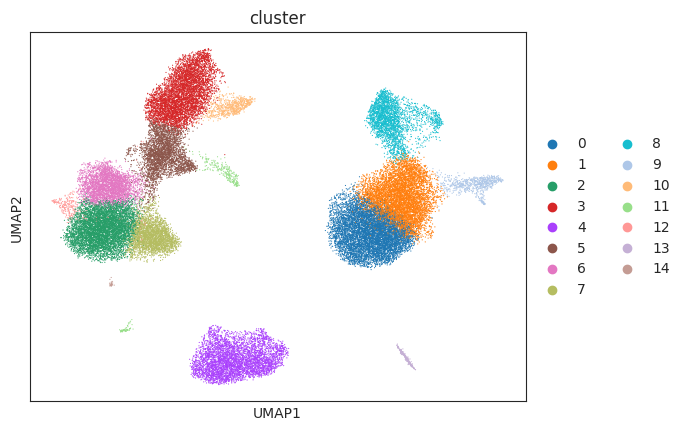

In [14]:
sc.pl.umap(adata_subsample, color="cluster")

In [15]:
# Находим маркерные гены
sc.tl.rank_genes_groups(adata_subsample, 'cluster', method='wilcoxon',
                        use_raw=False, pts=True)

# Извлекаем результаты в таблицу
marker_results = sc.get.rank_genes_groups_df(adata_subsample, group=None)
marker_results = marker_results[marker_results['pvals_adj'] < 0.05]
marker_results = marker_results[marker_results['logfoldchanges'] > 0.5]

print(f"Найдено {len(marker_results)} значимых маркерных генов")
for cluster in sorted(adata_subsample.obs['cluster'].unique()):
    top_markers = marker_results[marker_results['group'] == cluster].head(5)
    print(f"Кластер {cluster}: {', '.join(top_markers['names'].tolist())}")

Найдено 4945 значимых маркерных генов
Кластер 0: ENSG00000118965, ENSG00000172058, ENSG00000227678, ENSG00000180066, ENSG00000144290
Кластер 1: ENSG00000172058, ENSG00000144290, ENSG00000180066, ENSG00000228548, ENSG00000015568
Кластер 10: ENSG00000262211, ENSG00000186230, ENSG00000257017, ENSG00000240350, ENSG00000166803
Кластер 11: ENSG00000112232, ENSG00000205056, ENSG00000187240, ENSG00000174944, ENSG00000270103
Кластер 12: ENSG00000244734, ENSG00000224020, ENSG00000188536, ENSG00000213413, ENSG00000161610
Кластер 13: ENSG00000158525, ENSG00000101335, ENSG00000148346, ENSG00000236304, ENSG00000214548
Кластер 14: ENSG00000214548, ENSG00000176083, ENSG00000184709, ENSG00000239961, ENSG00000227486
Кластер 2: ENSG00000214548, ENSG00000161610, ENSG00000224020, ENSG00000148346, ENSG00000264745
Кластер 3: ENSG00000257275, ENSG00000228495, ENSG00000163687, ENSG00000168916, ENSG00000173262
Кластер 4: ENSG00000166091, ENSG00000172867, ENSG00000170891, ENSG00000273428, ENSG00000242550
Кластер

In [16]:
print("Колонки в adata_subsample.var:", list(adata_subsample.var.columns))

symbol_col = 'feature_name'

original_index = adata_subsample.var.index
adata_subsample.var.index = adata_subsample.var[symbol_col]
adata_subsample.var['original_id'] = original_index

sc.tl.rank_genes_groups(adata_subsample, 'cluster', method='wilcoxon', use_raw=False)

marker_results = sc.get.rank_genes_groups_df(adata_subsample, group=None)
print(marker_results.head())

Колонки в adata_subsample.var: ['feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std']
  group    names      scores  logfoldchanges  pvals  pvals_adj
0     0   S100A8  127.910133             NaN    0.0        0.0
1     0   S100A9  127.326797             NaN    0.0        0.0
2     0      LYZ  115.706406             NaN    0.0        0.0
3     0  S100A12  114.458328             NaN    0.0        0.0
4     0     VCAN  109.260521             NaN    0.0        0.0


In [17]:
marker_results

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,S100A8,127.910133,NaN,0.000000e+00,0.000000e+00
1,0,S100A9,127.326797,NaN,0.000000e+00,0.000000e+00
2,0,LYZ,115.706406,NaN,0.000000e+00,0.000000e+00
3,0,S100A12,114.458328,NaN,0.000000e+00,0.000000e+00
4,0,VCAN,109.260521,NaN,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
28330,14,S100A4,-4.422164,NaN,9.771703e-06,6.836573e-04
28331,14,MALAT1,-4.460588,NaN,8.173507e-06,5.938367e-04
28332,14,S100A8,-4.580021,NaN,4.649288e-06,4.239863e-04
28333,14,S100A6,-5.232152,NaN,1.675485e-07,2.637493e-05


In [18]:
print(f"Найдено {len(marker_results)} значимых маркерных генов")
for cluster in sorted(adata_subsample.obs['cluster'].unique()):
    top_markers = marker_results[marker_results['group'] == cluster].head(5)
    print(f"Кластер {cluster}: {', '.join(top_markers['names'].tolist())}")

Найдено 28335 значимых маркерных генов
Кластер 0: S100A8, S100A9, LYZ, S100A12, VCAN
Кластер 1: LYZ, CST3, FTH1, FTL, CTSS
Кластер 10: GNLY, CTSW, CMC1, NKG7, KLRF1
Кластер 11: STMN1, PCLAF, HMGB2, SMC4, TUBA1B
Кластер 12: RPL21, RPS18, IL7R, LTB, CD3D
Кластер 13: JCHAIN, IRF8, ALOX5AP, ITM2C, PLD4
Кластер 14: STMN1, SOX4, ANKRD28, RPS18, PRSS57
Кластер 2: RPL21, RPS18, LTB, IL7R, MALAT1
Кластер 3: NKG7, B2M, GZMA, CST7, CTSW
Кластер 4: CD74, CD79A, HLA-DRA, MS4A1, HLA-DPB1
Кластер 5: IL32, NKG7, GZMK, DUSP2, B2M
Кластер 6: LTB, IL32, IL7R, RPS18, CD3D
Кластер 7: RPS18, RPL21, CD8B, LINC02446, IL7R
Кластер 8: LST1, AIF1, FCGR3A, FTH1, SAT1
Кластер 9: HLA-DRA, HLA-DPB1, HLA-DRB1, HLA-DPA1, HLA-DQA1


In [19]:
marker_dict = {
    'CD4+ T cell': ['CD3D', 'CD3E', 'CD4', 'IL7R', 'CCR7'],
    'CD8+ T cell': ['CD3D', 'CD3E', 'CD8A', 'CD8B', 'GZMK', 'GZMB'],
    'B cell': ['CD79A', 'MS4A1', 'CD19', 'CD79B'],
    'Monocyte (CD14+)': ['CD14', 'LYZ', 'FCN1', 'S100A8', 'S100A9'],
    'Monocyte (CD16+)': ['FCGR3A', 'LYZ', 'MS4A7', 'CDKN1C'],
    'NK cell': ['NKG7', 'GNLY', 'KLRD1', 'NCAM1', 'KLRF1'],
    'Dendritic cell': ['FCER1A', 'CST3', 'CLEC10A', 'CD1C'],
    'Plasmacytoid DC': ['IL3RA', 'CLEC4C', 'IRF7', 'TCF4'],
    'Platelet': ['PPBP', 'PF4', 'GP9', 'TUBB1'],
    'Erythrocyte': ['HBA1', 'HBA2', 'HBB', 'AHSP'],
    'Stem cell': ['CD34', 'PROM1', 'THY1', 'KIT'],
    'Multipotent Progenitor (MPP)': ['CD34', 'FLT3', 'PTPRC', 'CD38', 'MLLT3', 'HLF'],
    'Progenitor Cell': ['MKI67', 'TOP2A', 'PCNA', 'STMN1', 'TYMS', 'CDC20']
}

In [20]:
def annotate_cluster(cluster_id, top_n=10):
    cluster_markers = marker_results[marker_results['group'] == cluster_id]
    top_genes = set(cluster_markers.head(top_n)['names'].tolist())

    scores = {}
    for cell_type, markers in marker_dict.items():
        overlap = len(top_genes.intersection(set(markers)))
        if overlap > 0:
            scores[cell_type] = overlap / len(markers) * 100

    if scores:
        best_match = max(scores.items(), key=lambda x: x[1])
        return best_match[0], best_match[1], scores
    return "Unknown", 0, {}


In [21]:
annotation_dict = {}
confidence_dict = {}

for cluster in sorted(adata_subsample.obs['cluster'].unique()):
    cell_type, confidence, all_scores = annotate_cluster(cluster, top_n=15)
    annotation_dict[cluster] = cell_type
    confidence_dict[cluster] = confidence

    print(f"Кластер {cluster}: {cell_type} (уверенность: {confidence:.1f}%)")
    if confidence < 50:
        print(f"  Альтернативы: {sorted(all_scores.items(), key=lambda x: x[1], reverse=True)[:3]}")

adata_subsample.obs['auto_annotation'] = adata_subsample.obs['cluster'].map(annotation_dict)

Кластер 0: Monocyte (CD14+) (уверенность: 80.0%)
Кластер 1: Monocyte (CD14+) (уверенность: 60.0%)
Кластер 10: NK cell (уверенность: 80.0%)
Кластер 11: Progenitor Cell (уверенность: 50.0%)
Кластер 12: Platelet (уверенность: 75.0%)
Кластер 13: Plasmacytoid DC (уверенность: 50.0%)
Кластер 14: Dendritic cell (уверенность: 25.0%)
  Альтернативы: [('Dendritic cell', 25.0), ('Progenitor Cell', 16.666666666666664)]
Кластер 2: CD4+ T cell (уверенность: 80.0%)
Кластер 3: NK cell (уверенность: 60.0%)
Кластер 4: B cell (уверенность: 75.0%)
Кластер 5: CD8+ T cell (уверенность: 50.0%)
Кластер 6: CD4+ T cell (уверенность: 60.0%)
Кластер 7: CD4+ T cell (уверенность: 80.0%)
Кластер 8: Monocyte (CD16+) (уверенность: 50.0%)
Кластер 9: Dendritic cell (уверенность: 100.0%)


In [22]:
symbol_col = 'feature_name'
id_col = 'original_id'

symbol_to_id = dict(zip(adata_subsample.var[symbol_col], adata_subsample.var[id_col]))
key_symbols = ['S100A9', 'S100A8', 'FCGR3A', 'CD74', 'GZMA', 'NKG7',
               'CD79A', 'MS4A1', 'JCHAIN', 'MZB1', 'IL4R', 'HLA-DRA']

ids_to_plot = []
for sym in key_symbols:
    if sym in symbol_to_id:
        ids_to_plot.append(symbol_to_id[sym])
        print(f"✓ {sym} -> {symbol_to_id[sym]}")
    else:
        print(f"✗ {sym} не найден в словаре")

print(f"\nУспешно переведено {len(ids_to_plot)} из {len(key_symbols)} генов")



✓ S100A9 -> ENSG00000163220
✓ S100A8 -> ENSG00000143546
✓ FCGR3A -> ENSG00000203747
✓ CD74 -> ENSG00000019582
✓ GZMA -> ENSG00000145649
✓ NKG7 -> ENSG00000105374
✓ CD79A -> ENSG00000105369
✓ MS4A1 -> ENSG00000156738
✓ JCHAIN -> ENSG00000132465
✓ MZB1 -> ENSG00000170476
✓ IL4R -> ENSG00000077238
✓ HLA-DRA -> ENSG00000204287

Успешно переведено 12 из 12 генов


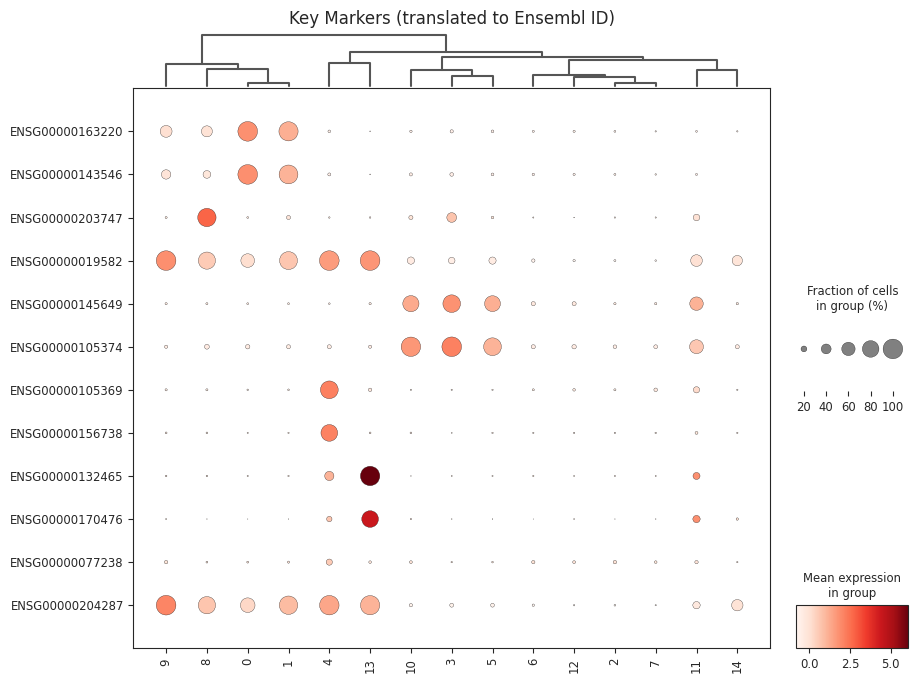

In [23]:
sc.pl.dotplot(adata_subsample,
                var_names=ids_to_plot[:12],
                groupby='cluster',
                use_raw=True,
                dendrogram=True,
                swap_axes=True,
                figsize=(10, 8),
                title='Key Markers (translated to Ensembl ID)')

In [25]:
adata_subsample

AnnData object with n_obs × n_vars = 44493 × 1889
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'cluster', 'auto_annotation'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'original_id'
    un

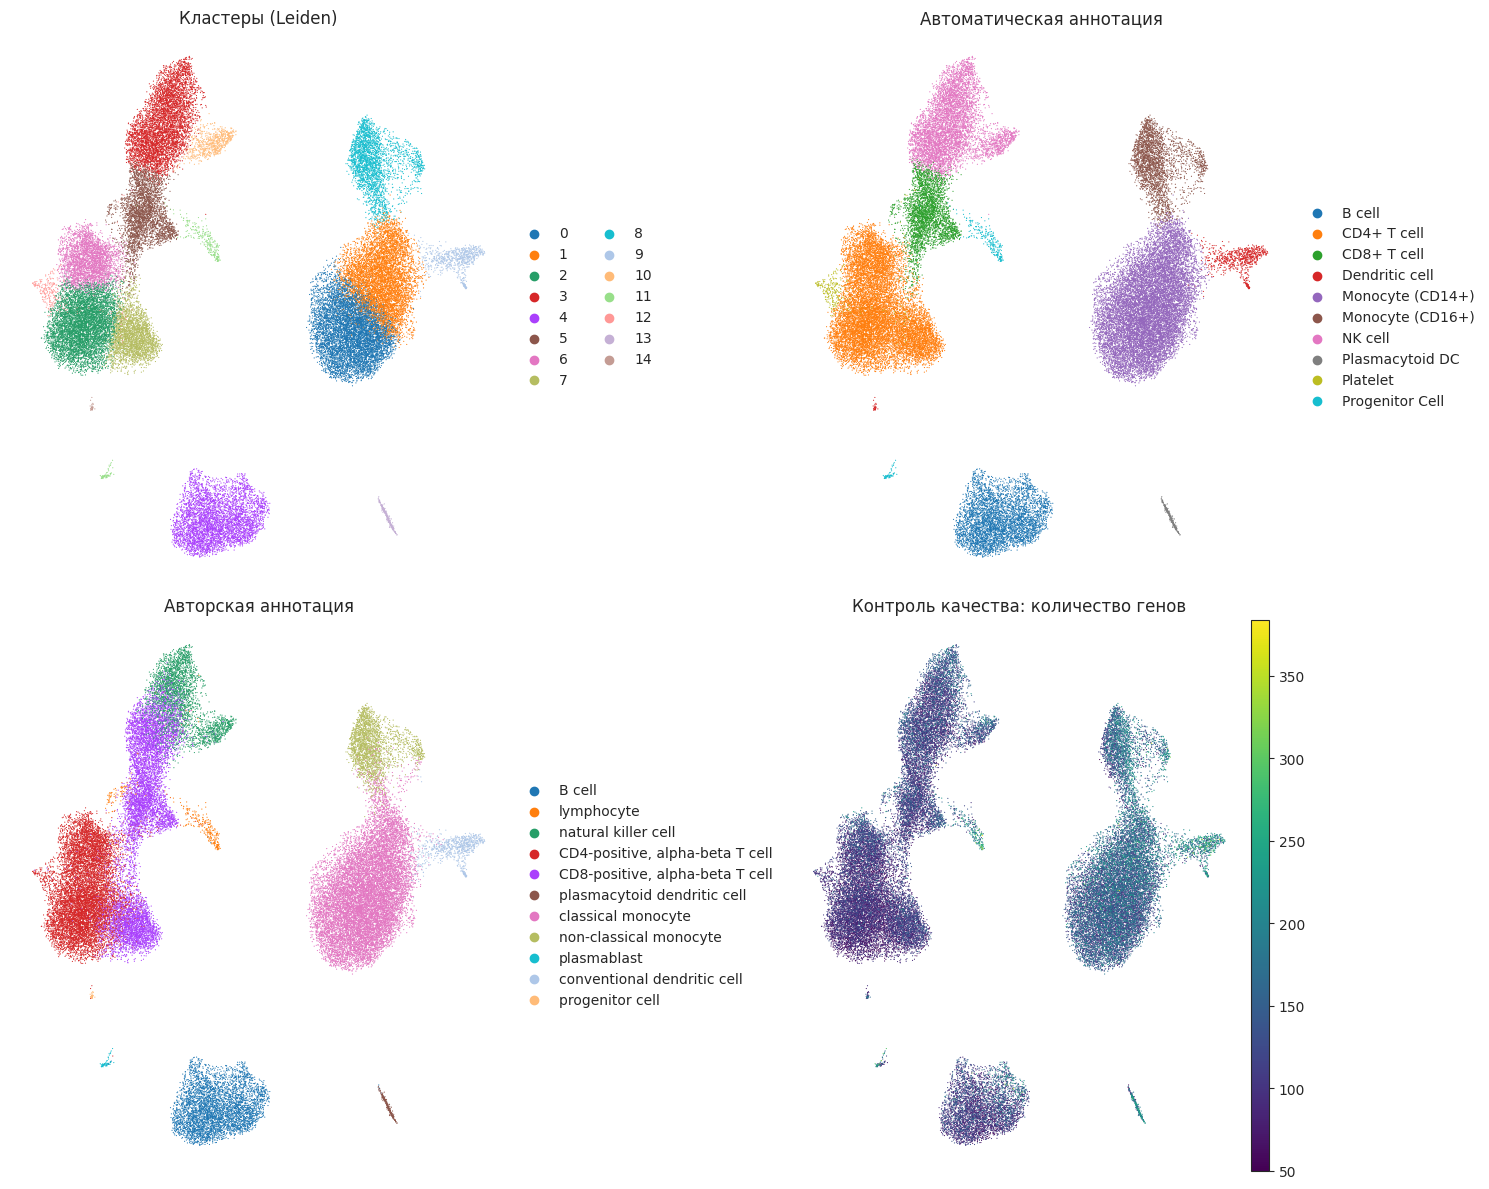

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Кластеры Leiden
sc.pl.umap(adata_subsample, color=['cluster'], ax=axes[0, 0],
           title='Кластеры (Leiden)', show=False, frameon=False)

# 2. Автоматическая аннотация
sc.pl.umap(adata_subsample, color=['auto_annotation'], ax=axes[0, 1],
           title='Автоматическая аннотация', show=False, frameon=False)

# 3. Сравнение с авторской (если есть)
if 'cell_type' in adata_subsample.obs.columns:
    sc.pl.umap(adata_subsample, color=['cell_type'], ax=axes[1, 0],
               title='Авторская аннотация', show=False, frameon=False)

    # 4. Уверенность аннотации
sc.pl.umap(adata_subsample, color=['n_genes'], ax=axes[1, 1],
           title='Контроль качества: количество генов',
           show=False, frameon=False, cmap='viridis')

plt.tight_layout()
plt.show()


In [32]:
if all(col in adata_subsample.obs.columns for col in ['donor_id', 'disease', 'auto_annotation']):
    cell_counts_final = adata_subsample.obs.groupby(
        ['donor_id', 'disease', 'auto_annotation']
    ).size().unstack(fill_value=0)

    cell_counts_final.to_csv('cell_counts_auto_annotated.csv')

    adata_subsample.write('adata_annotated.h5ad', compression='gzip')

In [33]:
required_columns = ['donor_id', 'disease', 'auto_annotation']
missing_columns = [col for col in required_columns if col not in adata_subsample.obs.columns]

if missing_columns:
    print(f"ОШИБКА: Отсутствуют колонки: {missing_columns}")
    print("Доступные колонки в adata_subsample.obs:")
    print(list(adata_subsample.obs.columns))
else:
    cell_counts = adata_subsample.obs.groupby(
        ['donor_id', 'disease', 'auto_annotation']
    ).size().unstack(fill_value=0)

    cell_counts = cell_counts.reset_index()
    print(cell_counts['disease'].value_counts())

    cell_counts['total_cells'] = cell_counts.iloc[:, 2:].sum(axis=1)
    print(f"\nМинимальное количество клеток на донора: {cell_counts['total_cells'].min()}")
    print(f"Максимальное количество клеток на донора: {cell_counts['total_cells'].max()}")


Таблица создана. Размер: (40, 12)

Количество доноров: 40
Типы клеток: ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'Dendritic cell', 'Monocyte (CD14+)', 'Monocyte (CD16+)', 'NK cell', 'Plasmacytoid DC', 'Platelet', 'Progenitor Cell']

Распределение доноров по группам:
disease
systemic lupus erythematosus    20
normal                          20
Name: count, dtype: int64

Минимальное количество клеток на донора: 0
Максимальное количество клеток на донора: 4404


In [34]:
cell_counts.to_csv('cell_counts_for_analysis.csv', index=False)

donor_metadata = cell_counts[['donor_id', 'disease']].copy()
donor_metadata.to_csv('donor_metadata.csv', index=False)

cell_type_descriptions = pd.DataFrame({
    'cell_type': cell_counts.columns[2:-1] if 'total_cells' in cell_counts.columns else cell_counts.columns[2:]
})
cell_type_descriptions.to_csv('cell_type_descriptions.csv', index=False)

In [35]:
donor_metadata

auto_annotation,donor_id,disease
0,1031,systemic lupus erythematosus
1,1031,normal
2,1165,systemic lupus erythematosus
3,1165,normal
4,1225,systemic lupus erythematosus
5,1225,normal
6,1270,systemic lupus erythematosus
7,1270,normal
8,1320,systemic lupus erythematosus
9,1320,normal


In [37]:
disease_candidates = ['disease']

ID доноров с 0 клеток: ['1031', '1165', '1225', '1270', '1320', '1324', '1337', '1615', '1754', '1804', 'HC-020', 'HC-519', 'HC-563', 'HC-578', 'HC-585', 'IGTB1539', 'IGTB1762', 'IGTB1789', 'IGTB1895', 'IGTB2065']

Распределение нулевых доноров по заболеванию:
  systemic lupus erythematosus: 10 доноров
  normal: 10 доноров
РАСПРЕДЕЛЕНИЕ ПО ЗАБОЛЕВАНИЮ ПОСЛЕ ФИЛЬТРАЦИИ:
  systemic lupus erythematosus: 10 доноров (50.0%)
  normal: 10 доноров (50.0%)


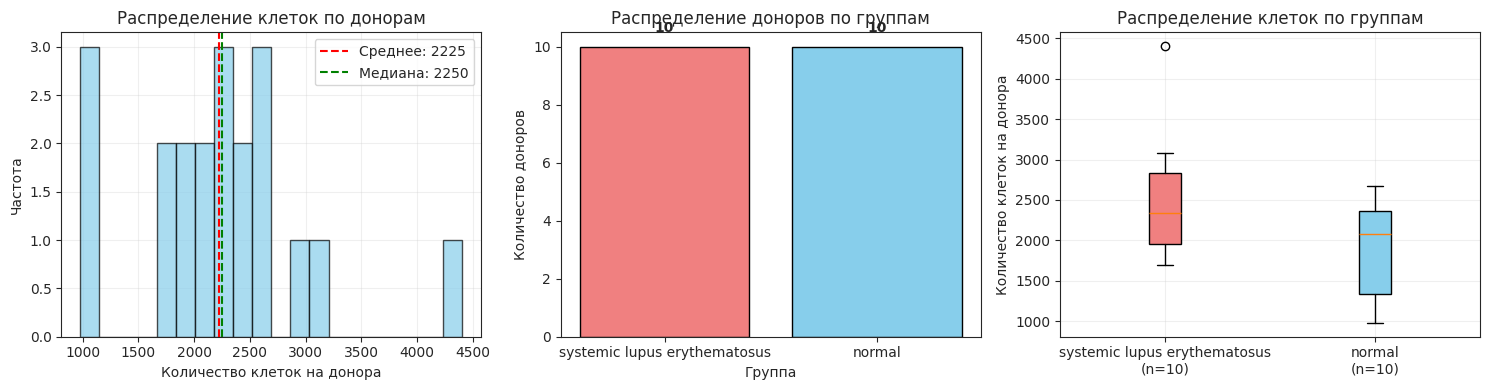

In [38]:
if 'total_cells' not in cell_counts.columns:
    service_cols = ['donor_id']
    disease_candidates = [col for col in cell_counts.columns if 'disease' in col.lower() or 'condition' in col.lower()]
    if disease_candidates:
        service_cols.append(disease_candidates[0])

    cell_type_cols = [col for col in cell_counts.columns if col not in service_cols]
    cell_counts['total_cells'] = cell_counts[cell_type_cols].sum(axis=1)

if (cell_counts['total_cells'] == 0).sum() > 0:
    zero_donors = cell_counts[cell_counts['total_cells'] == 0]['donor_id'].tolist()
    print(f"ID доноров с 0 клеток: {zero_donors}")

    if disease_candidates:
        disease_col = disease_candidates[0]
        zero_by_disease = cell_counts[cell_counts['total_cells'] == 0][disease_col].value_counts()
        print(f"\nРаспределение нулевых доноров по заболеванию:")
        for condition, count in zero_by_disease.items():
            print(f"  {condition}: {count} доноров")

original_size = len(cell_counts)

cell_counts_filtered = cell_counts[cell_counts['total_cells'] > 0].copy()

service_cols = ['donor_id', 'total_cells']
disease_candidates = [col for col in cell_counts_filtered.columns if 'disease' in col.lower() or 'condition' in col.lower()]
if disease_candidates:
    service_cols.append(disease_candidates[0])

cell_type_cols = [col for col in cell_counts_filtered.columns if col not in service_cols]


if disease_candidates:
    disease_col = disease_candidates[0]
    print(f"РАСПРЕДЕЛЕНИЕ ПО ЗАБОЛЕВАНИЮ ПОСЛЕ ФИЛЬТРАЦИИ:")
    disease_dist = cell_counts_filtered[disease_col].value_counts()
    for condition, count in disease_dist.items():
        percentage = (count / len(cell_counts_filtered)) * 100
        print(f"  {condition}: {count} доноров ({percentage:.1f}%)")

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(cell_counts_filtered['total_cells'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(cell_counts_filtered['total_cells'].mean(), color='red', linestyle='--', label=f'Среднее: {cell_counts_filtered["total_cells"].mean():.0f}')
axes[0].axvline(cell_counts_filtered['total_cells'].median(), color='green', linestyle='--', label=f'Медиана: {cell_counts_filtered["total_cells"].median():.0f}')
axes[0].set_xlabel('Количество клеток на донора')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение клеток по донорам')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if disease_candidates:
    disease_col = disease_candidates[0]
    disease_counts = cell_counts_filtered[disease_col].value_counts()
    colors = ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(disease_counts)]
    axes[1].bar(disease_counts.index, disease_counts.values, color=colors, edgecolor='black')
    axes[1].set_xlabel('Группа')
    axes[1].set_ylabel('Количество доноров')
    axes[1].set_title('Распределение доноров по группам')
    for i, (idx, val) in enumerate(disease_counts.items()):
        axes[1].text(i, val + 0.5, str(val), ha='center', fontweight='bold')

if disease_candidates:
    import pandas as pd
    disease_col = disease_candidates[0]
    boxplot_data = []
    labels = []
    for condition in cell_counts_filtered[disease_col].unique():
        condition_data = cell_counts_filtered[cell_counts_filtered[disease_col] == condition]['total_cells']
        boxplot_data.append(condition_data)
        labels.append(f"{condition}\n(n={len(condition_data)})")

    bp = axes[2].boxplot(boxplot_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(boxplot_data)]):
        patch.set_facecolor(color)
    axes[2].set_ylabel('Количество клеток на донора')
    axes[2].set_title('Распределение клеток по группам')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('donor_filtering_results.png', dpi=150, bbox_inches='tight')
plt.show()

cell_counts = cell_counts_filtered.copy()

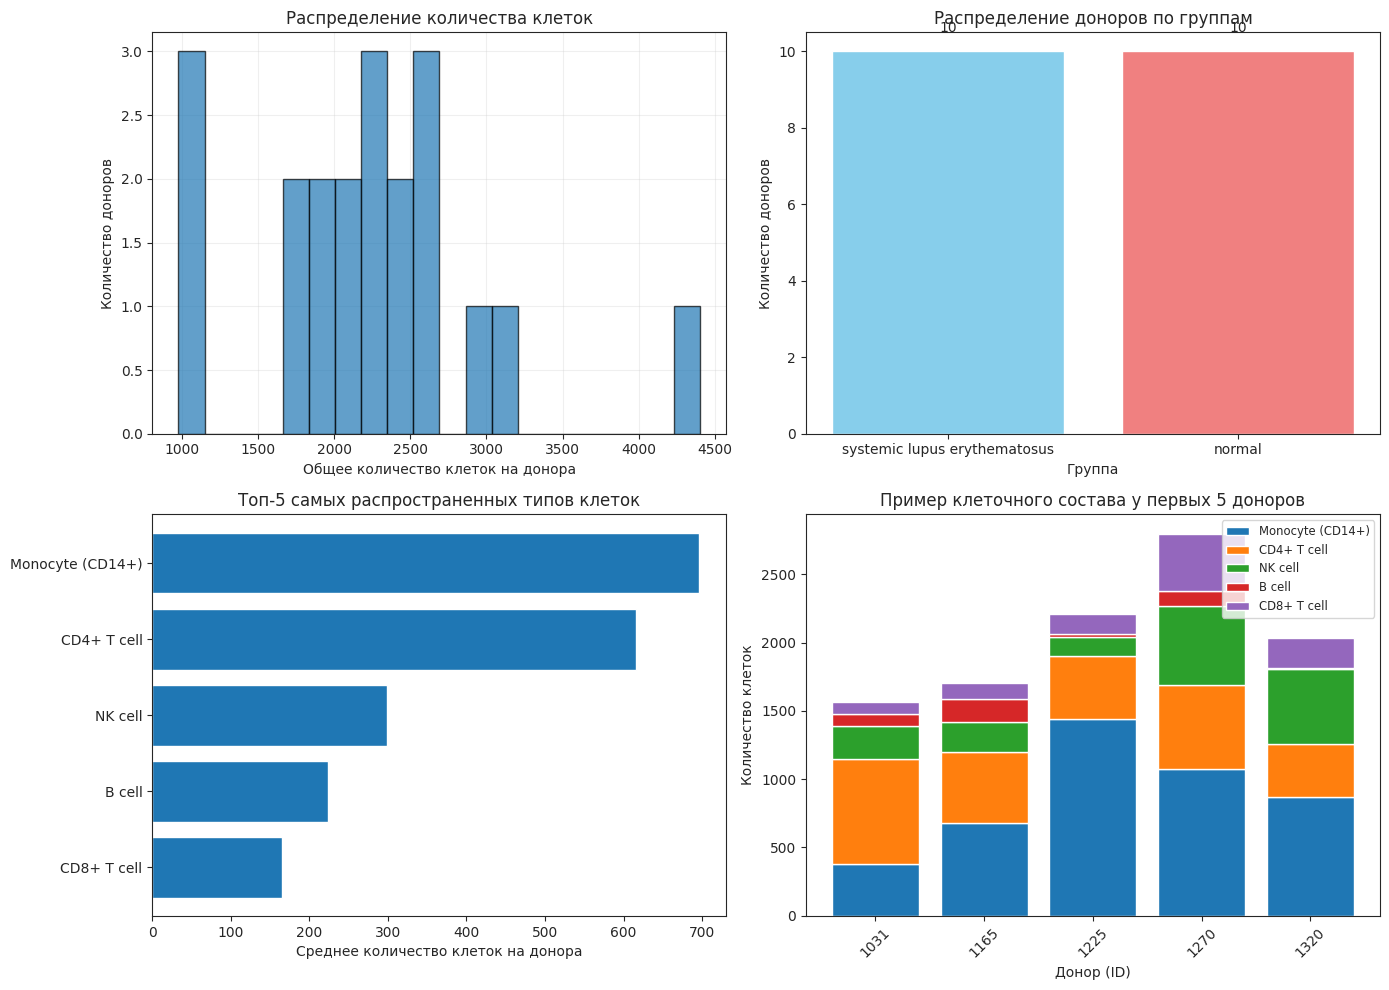

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# График 1: Распределение общего количества клеток по донорам
axes[0, 0].hist(cell_counts['total_cells'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Общее количество клеток на донора')
axes[0, 0].set_ylabel('Количество доноров')
axes[0, 0].set_title('Распределение количества клеток')
axes[0, 0].grid(True, alpha=0.3)

# График 2: Количество доноров в каждой группе
group_counts = cell_counts['disease'].value_counts()
axes[0, 1].bar(group_counts.index, group_counts.values, color=['skyblue', 'lightcoral'])
axes[0, 1].set_xlabel('Группа')
axes[0, 1].set_ylabel('Количество доноров')
axes[0, 1].set_title('Распределение доноров по группам')
for i, v in enumerate(group_counts.values):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center')

# График 3: Топ-5 самых распространенных типов клеток (среднее по всем донорам)
mean_composition = cell_counts.iloc[:, 2:-1].mean().sort_values(ascending=False).head(5)
axes[1, 0].barh(range(len(mean_composition)), mean_composition.values)
axes[1, 0].set_yticks(range(len(mean_composition)))
axes[1, 0].set_yticklabels(mean_composition.index)
axes[1, 0].set_xlabel('Среднее количество клеток на донора')
axes[1, 0].set_title('Топ-5 самых распространенных типов клеток')
axes[1, 0].invert_yaxis()

# График 4: Пример композиции для нескольких доноров (первые 5)
sample_donors = cell_counts.head(5)
x = range(len(sample_donors))
bottom = np.zeros(len(sample_donors))

# Берем топ-5 типов клеток по распространенности
top_cell_types = mean_composition.index.tolist()

for i, cell_type in enumerate(top_cell_types):
    if cell_type in sample_donors.columns:
        axes[1, 1].bar(x, sample_donors[cell_type], bottom=bottom, label=cell_type)
        bottom += sample_donors[cell_type].values

axes[1, 1].set_xlabel('Донор (ID)')
axes[1, 1].set_ylabel('Количество клеток')
axes[1, 1].set_title('Пример клеточного состава у первых 5 доноров')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(sample_donors['donor_id'].tolist(), rotation=45)
axes[1, 1].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.savefig('data_quality_check.png', dpi=150, bbox_inches='tight')
plt.show()

In [40]:
proportions = cell_counts.copy()
cell_type_columns = [col for col in proportions.columns
                     if col not in ['donor_id', 'disease', 'total_cells']]

for col in cell_type_columns:
    proportions[col] = proportions[col] / proportions['total_cells']

proportions.to_csv('cell_proportions_for_ttest.csv', index=False)

group_sle = proportions[proportions['disease'] == 'systemic lupus erythematosus']
group_normal = proportions[proportions['disease'] == 'normal']

In [41]:
print("Доступные колонки в cell_counts:")
print(cell_counts.columns.tolist())

disease_col = 'disease'

service_cols = ['donor_id', 'total_cells']
if disease_col:
    service_cols.append(disease_col)

cell_type_cols = [col for col in cell_counts.columns if col not in service_cols]

sccoda_df = cell_counts[cell_type_cols + [disease_col]].copy()

if disease_col != 'condition':
    sccoda_df = sccoda_df.rename(columns={disease_col: 'condition'})
    print(f"Переименовал '{disease_col}' в 'condition' для scCODA")


adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["condition"]
)

adata_sccoda.write('cell_counts_sccoda.h5ad', compression='gzip')
sccoda_csv = cell_counts[['donor_id'] + cell_type_cols + [disease_col]].copy()
sccoda_csv.to_csv('cell_counts_sccoda_format.csv', index=False)


if 'cell_counts_sccoda_format.csv' in globals() or 'sccoda_df' in globals():
    sample_data = sccoda_df.head(3) if 'sccoda_df' in globals() else pd.read_csv('cell_counts_sccoda_format.csv').head(3)

    if len(cell_type_cols) > 5:
        show_cols = cell_type_cols[:3] + ['...'] + cell_type_cols[-2:] + ['condition']
    else:
        show_cols = cell_type_cols + ['condition']

    for idx, row in sample_data.iterrows():
        if len(cell_type_cols) > 5:
            first_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[:2]])
            last_types = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols[-2:]])
            print(f"Донор {idx+1}: {first_types}, ..., {last_types}, Условие: {row['condition']}")
        else:
            types_str = ", ".join([f"{col}: {int(row[col])}" for col in cell_type_cols])
            print(f"Донор {idx+1}: {types_str}, Условие: {row['condition']}")

Доступные колонки в cell_counts:
['donor_id', 'disease', 'B cell', 'CD4+ T cell', 'CD8+ T cell', 'Dendritic cell', 'Monocyte (CD14+)', 'Monocyte (CD16+)', 'NK cell', 'Plasmacytoid DC', 'Platelet', 'Progenitor Cell', 'total_cells']
Переименовал 'disease' в 'condition' для scCODA
Донор 1: B cell: 84, CD4+ T cell: 775, ..., Platelet: 14, Progenitor Cell: 38, Условие: systemic lupus erythematosus
Донор 3: B cell: 165, CD4+ T cell: 520, ..., Platelet: 9, Progenitor Cell: 15, Условие: systemic lupus erythematosus
Донор 5: B cell: 23, CD4+ T cell: 466, ..., Platelet: 12, Progenitor Cell: 9, Условие: systemic lupus erythematosus


t-test analysis:

In [42]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

proportions = pd.read_csv('cell_counts_for_analysis.csv', index_col=0)
metadata = pd.read_csv('donor_metadata.csv')

analysis_df = proportions.merge(
    metadata,
    left_index=True,
    right_on='donor_id',
    suffixes=('_prop', '_meta')
)

cell_type_columns = [col for col in proportions.columns
                     if col not in ['disease', 'total_cells']]

group_col = 'disease_prop'
groups = analysis_df[group_col].unique()
if len(groups) == 2:
    group1, group2 = groups[0], groups[1]
    print(f"Сравниваем группы: '{group1}' vs '{group2}'")

    results = []
    for cell_type in cell_type_columns:
        data_group1 = analysis_df[analysis_df[group_col] == group1][cell_type]
        data_group2 = analysis_df[analysis_df[group_col] == group2][cell_type]

        if len(data_group1) >= 3 and len(data_group2) >= 3:
            t_stat, p_val = ttest_ind(data_group1, data_group2, equal_var=False, nan_policy='omit')
            mean_diff = data_group1.mean() - data_group2.mean()
            results.append({
                'cell_type': cell_type,
                'mean_diff': mean_diff,
                't_statistic': t_stat,
                'p_value': p_val
            })

    ttest_results = pd.DataFrame(results)

    if len(ttest_results) > 0:
        ttest_results['p_value_adj'] = multipletests(ttest_results['p_value'], method='fdr_bh')[1]
        ttest_results['significant'] = ttest_results['p_value_adj'] < 0.1

        ttest_results.sort_values('p_value').to_csv('ttest_results.csv', index=False)
        print(f"Значимых типов клеток (FDR < 0.05): {ttest_results['significant'].sum()} из {len(ttest_results)}")

        print("Топ-5 значимых типов клеток по t-test:")
        print(ttest_results[ttest_results['significant']].sort_values('p_value').head(5)[['cell_type', 'mean_diff', 'p_value_adj']])
else:
    print(f"Найдено {len(groups)} групп. Ожидается 2 группы для t-test.")

Сравниваем группы: 'systemic lupus erythematosus' vs 'normal'
Значимых типов клеток (FDR < 0.05): 0 из 10
Топ-5 значимых типов клеток по t-test:
Empty DataFrame
Columns: [cell_type, mean_diff, p_value_adj]
Index: []


In [44]:
ttest_results

,cell_type,mean_diff,t_statistic,p_value,p_value_adj,significant
0,B cell,-9.75,-0.229157,0.819389,0.922890,False
1,CD4+ T cell,-18.50,-0.214681,0.830601,0.922890,False
2,CD8+ T cell,23.70,1.016112,0.312960,0.521600,False
3,Dendritic cell,0.15,0.027129,0.978430,0.978430,False
4,Monocyte (CD14+),165.25,1.728261,0.088943,0.177886,False
5,Monocyte (CD16+),54.30,2.062506,0.044829,0.177886,False
6,NK cell,74.80,1.803543,0.076013,0.177886,False
7,Plasmacytoid DC,-3.45,-1.803297,0.075962,0.177886,False
8,Platelet,1.05,0.437844,0.662714,0.922890,False
9,Progenitor Cell,5.10,1.807909,0.076343,0.177886,False


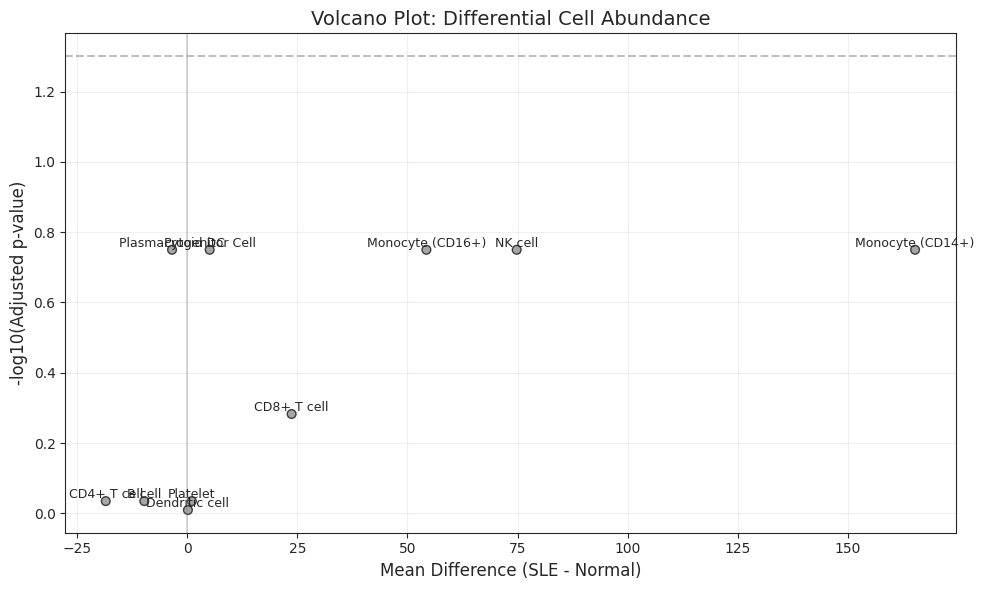

In [43]:
plt.figure(figsize=(10, 6))

colors = ['red' if sig else 'gray' for sig in ttest_results['significant']]
sizes = [80 if sig else 40 for sig in ttest_results['significant']]

plt.scatter(ttest_results['mean_diff'],
            -np.log10(ttest_results['p_value_adj']),
            c=colors, s=sizes, alpha=0.7, edgecolors='black')

for i, row in ttest_results.iterrows():
    plt.text(row['mean_diff'],
             -np.log10(row['p_value_adj']),
             row['cell_type'],
             fontsize=9, ha='center', va='bottom')

plt.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='-', alpha=0.3)

plt.xlabel('Mean Difference (SLE - Normal)', fontsize=12)
plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
plt.title('Volcano Plot: Differential Cell Abundance', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volcano_plot.png', dpi=300)
plt.show()

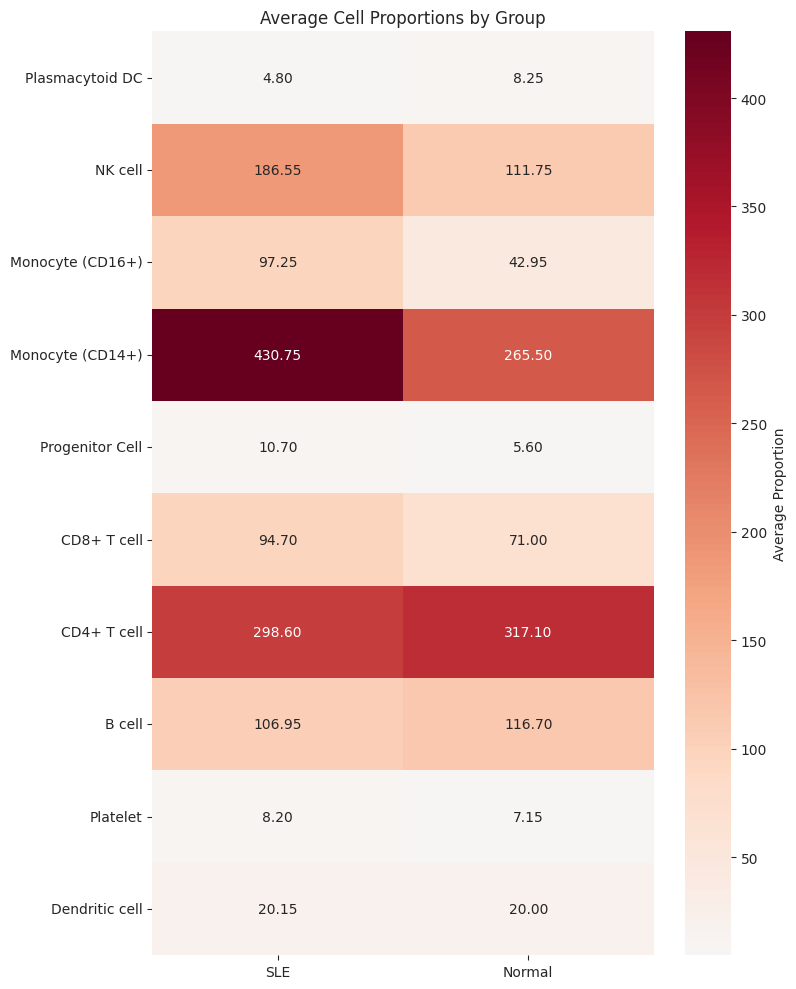

In [45]:
top_cells = ttest_results.sort_values('p_value_adj').head(15)['cell_type'].tolist()

group_means = pd.DataFrame({
    'SLE': analysis_df[analysis_df[group_col] == group1][top_cells].mean(),
    'Normal': analysis_df[analysis_df[group_col] == group2][top_cells].mean()
})

plt.figure(figsize=(8, 10))
sns.heatmap(group_means,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Average Proportion'})
plt.title('Average Cell Proportions by Group')
plt.tight_layout()
plt.savefig('heatmap_group_means.png', dpi=300)
plt.show()

scCODA analysis:

In [46]:
counts_df = pd.read_csv('cell_counts_sccoda_format.csv', index_col=0)
metadata_df = pd.read_csv('donor_metadata.csv').set_index('donor_id')

if 'disease' in metadata_df.columns:
    metadata_df = metadata_df.rename(columns={'disease': 'condition'})

cols_to_drop = ['disease', 'total_cells', 'auto_annotation']
existing_cols = [col for col in cols_to_drop if col in counts_df.columns]
if existing_cols:
    counts_df = counts_df.drop(columns=existing_cols)

sccoda_df = counts_df.join(metadata_df, how='inner')

adata_sccoda = dat.from_pandas(
    sccoda_df,
    covariate_columns=["condition"]
)

In [47]:
model = mod.CompositionalAnalysis(
    data=adata_sccoda,
    formula="condition",
    reference_cell_type="automatic"
)

results = model.sample_hmc()

results.save("sccoda_results")

Automatic reference selection! Reference cell type set to Platelet


100%|██████████| 20000/20000 [03:44<00:00, 88.97it/s]


MCMC sampling finished. (283.765 sec)
Acceptance rate: 45.6%


In [48]:
print("Краткие результаты scCODA:")
summary = results.summary()
print(summary)

credible_effects = results.credible_effects()
print(f"Значимо измененные типы клеток (вероятность > 0.95): {credible_effects.sum()}")

Краткие результаты scCODA:
Compositional Analysis summary:

Data: 40 samples, 10 cell types
Reference index: 8
Formula: condition

Intercepts:
                  Final Parameter  Expected Sample
Cell Type                                         
B cell                      0.869       175.717452
CD4+ T cell                 2.025       558.289318
CD8+ T cell                 0.909       182.888617
Dendritic cell             -0.072        68.571522
Monocyte (CD14+)            2.200       665.060037
Monocyte (CD16+)            0.726       152.303816
NK cell                     1.427       307.009078
Plasmacytoid DC            -0.692        36.887669
Platelet                   -0.657        38.201597
Progenitor Cell            -0.618        39.720893


Effects:
                                                            Final Parameter  \
Covariate                                 Cell Type                           
condition[T.systemic lupus erythematosus] B cell                        0.0 

<Axes: xlabel='Cell type', ylabel='Proportion'>

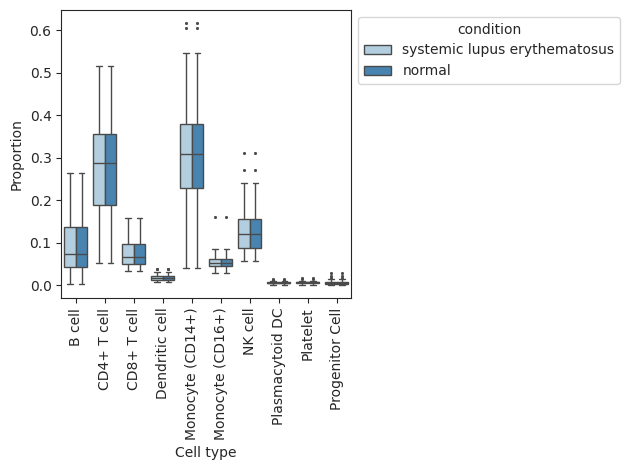

In [49]:
viz.boxplots(adata_sccoda, feature_name="condition")

Мы видим, что оба метода не показали никаких значимых изменений, потому что их нет. Это противоречит литературным данным (в статье показали значимое сокращение CD4+) -- я полагаю, это из-за того, что клетки каждого донора выбирались случайным образом и не отображают реальной пропорции типов клеток. Более того, у нас не такая большая выборка в силу ограничений в вычислительной мощности.
Во втором ноутбуке есть тест на более простом датасете.